# Text exploration

Here we explore the text data we have so far. We want to see what sort of analyses are possible.

In [41]:
import os
import re
import json
import numpy as np
import pandas as pd
from utils import multicore_apply

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

pd.set_option('display.max_columns', None)

## Load the data

In [86]:
with open('../data/old_output.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [87]:
papers

,url,text
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ..."
1,https://paperspast.natlib.govt.nz/newspapers/D...,FARM- AND ■■ •'■ FOR THE COMING SEASON WE 'HAV...
2,https://paperspast.natlib.govt.nz/newspapers/W...,Gazette Office. OF ALL THE ACCOUNTS owing to t...
3,https://paperspast.natlib.govt.nz/newspapers/D...,LAND NOTICES. . ONLY ONE LEFT. BEAUTIFULTOUR-R...
4,https://paperspast.natlib.govt.nz/newspapers/D...,LAND NOTICES. Y I S.;T T L 0 W R Y B A Y <' ? ...
...,...,...
48275,https://paperspast.natlib.govt.nz/newspapers/W...,A TRAMCAR ACCIDENT.\nTWO PEOPLE. KILLED. Recei...
48276,https://paperspast.natlib.govt.nz/newspapers/W...,A BARQUE WRECKED.\nTHE CREW SAVED. Received Ju...
48277,https://paperspast.natlib.govt.nz/newspapers/W...,THE TRAIN ACCIDENT IN ENGLAND.\nMARVELLOUS ESC...
48278,https://paperspast.natlib.govt.nz/newspapers/W...,"THE LANDS SCANDAL.\nReoeived July 4, 1.14 a.m...."


In [88]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,10,12,2.12.5
1,https://paperspast.natlib.govt.nz/newspapers/D...,FARM- AND ■■ •'■ FOR THE COMING SEASON WE 'HAV...,DOM,1907,12,31,2.74.4
2,https://paperspast.natlib.govt.nz/newspapers/W...,Gazette Office. OF ALL THE ACCOUNTS owing to t...,WI,1845,08,02,2.12.1
3,https://paperspast.natlib.govt.nz/newspapers/D...,LAND NOTICES. . ONLY ONE LEFT. BEAUTIFULTOUR-R...,DOM,1907,12,31,2.75.6
4,https://paperspast.natlib.govt.nz/newspapers/D...,LAND NOTICES. Y I S.;T T L 0 W R Y B A Y <' ? ...,DOM,1907,12,31,2.75.3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='index'>

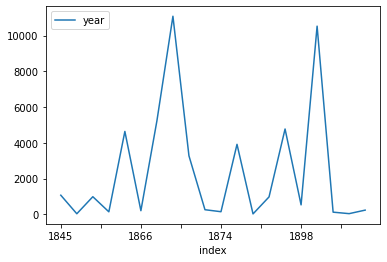

In [110]:
papers.year.value_counts().sort_index().to_frame().reset_index().plot(kind = 'line', x = 'index', y = 'year')

In [62]:
print(len(papers.newspaper_id.unique()))

24


In [5]:
papers.newspaper_id.value_counts()

WEST      11079
WAG       10525
BA         4776
AMBPA      3919
WH         3885
WT         2549
BH         2473
WCT        2167
WAIST      1347
WI         1075
WC          991
WOODEX      980
BOPT        729
WDA         535
WSTAR       264
GISH        241
DUNST       169
WANANG      152
WAKAM       146
DOM         127
WAIPO        44
GRA          40
WHETU        38
WDT          29
Name: newspaper_id, dtype: int64

In [6]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [7]:
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 134k/134k [00:02<00:00, 64.7kit/s]  
133793it [00:00, 522338.89it/s]


,url,text,newspaper_id,year,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,12,2.12.5,"Kawarau Adverisemens. John hethebington, Post ...",Kawarau Adverisemens.
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,12,2.12.5,"Kawarau Adverisemens. John hethebington, Post ...","John hethebington, Post - Office Store, CROMWE..."
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,12,2.12.5,"Kawarau Adverisemens. John hethebington, Post ...",Also a Large and Yaried Assortment of Gold Pur...
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,12,2.12.5,"Kawarau Adverisemens. John hethebington, Post ...",If you want the Best Value for Money* Don't Fo...
0,https://paperspast.natlib.govt.nz/newspapers/D...,"Kawarau Adverisemens. John hethebington, Post ...",DUNST,1866,12,2.12.5,"Kawarau Adverisemens. John hethebington, Post ...",The best Stabling in the Township.


<AxesSubplot:>

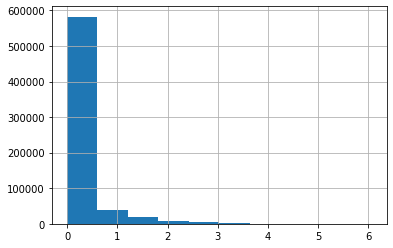

In [42]:
np.log10(pd.Series([w for s in papers['clean_sentence'] for w in s.split()]).value_counts()).hist()

In [13]:
papers['clean_sentence'] = (papers
    .sentence
    .str.replace("[\-—]+", " ")
    .str.replace("[^\w\s]+", "")
    .str.lower()
)

In [78]:
papers['num_words'] = papers.clean_sentence.apply(lambda x: len(x.split()))

<AxesSubplot:ylabel='newspaper_id'>

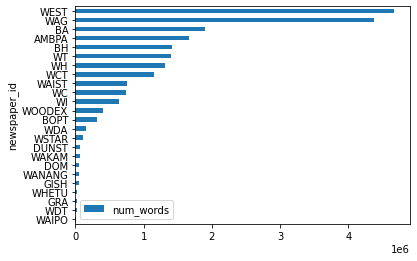

In [84]:
papers.groupby('newspaper_id').agg({'num_words': np.sum}).sort_values('num_words').plot(kind = 'barh')

In [29]:
newspaper_corpus = papers.groupby('newspaper_id').agg({'clean_sentence': lambda s: ' '.join(s)}).clean_sentence

In [103]:
tfidf = TfidfVectorizer(stop_words = 'english', min_df = 3, ngram_range = (1,4))

In [104]:
%%time
X = tfidf.fit_transform(newspaper_corpus)

CPU times: user 1min, sys: 1.87 s, total: 1min 2s
Wall time: 1min 2s


In [105]:
X

<24x239224 sparse matrix of type '<class 'numpy.float64'>'
	with 1218021 stored elements in Compressed Sparse Row format>

In [106]:
print(tfidf.get_feature_names()[:10])

['00', '00 00', '00 50', '00 acres', '00 auckland', '00 boxes', '00 feet', '00 instructed', '00 wanganui', '00 years']


## Show the top 10 words by TFIDF

In [111]:
def get_top_tf_idf_words(response, top_n=2):
    feature_names = np.array(tfidf.get_feature_names())
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

top_tfidf = (pd.DataFrame(
    dict(zip(
        newspaper_corpus.index, 
        [get_top_tf_idf_words(response, 10) for response in X])))
    .transpose()
)
top_tfidf

,0,1,2,3,4,5,6,7,8,9
AMBPA,akaroa,mr,bay,new,christchurch,1877,best,road,street,6d
BA,mr,norsewood,ormondville,new,napier,hotel,business,best,1888,6d
BH,mr,tokomairiro,dunedin,new,time,said,clutha,dunbar,land,street
BOPT,tauranga,hotel,mr,auckland,tho,good,public,street,office,new
DOM,tho,wellington,new,street,pm,mr,december,bo,good,day
DUNST,clyde,mr,hotel,street,dunstan,dunedin,mining,alexandra,cromwell,bathans
GISH,mr,new,mrs,miss,gisborne,price,day,zealand,10,new zealand
GRA,greymouth,nelson,sullivan,mr,hokitika,hotel,quay,new,mawhera,street
WAG,masterton,acres,street,good,acre,new,price,sovs,mr,house
WAIPO,awamutu,te awamutu,te,ohaupo,pirongia,january,year,mr,sale,stock
